# Puzzle Solver 🧩

In [1]:
# Don't worry about it it just used for easier coding:
import os
import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()


Saving Puzzle_1_160.zip to Puzzle_1_160.zip


In [3]:
import zipfile

with zipfile.ZipFile("Puzzle_1_160.zip", 'r') as zip_ref:
    zip_ref.extractall("puzzle_data11")  # همه فایل‌ها در پوشه puzzle_data قرار می‌گیرن


In [4]:
# path of dataset change with your own path
folder_path = r"puzzle_data11/Puzzle_1_160"

In [5]:
#Read Images
output_file = os.path.join(folder_path, "Output.tif")
patch_files = glob.glob(os.path.join(folder_path, "Patch_*.tif"))

corners_img = np.array(Image.open(output_file))
# Get copy of image to edit it later
base_img = corners_img.copy()

patches = [np.array(Image.open(patch_file)) for patch_file in patch_files]

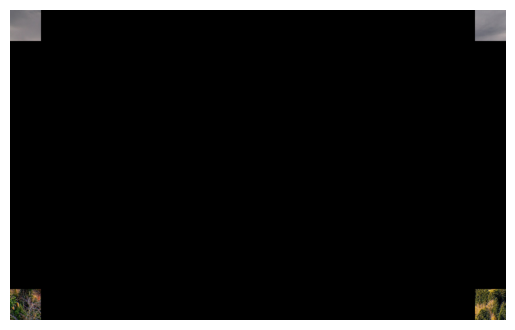

In [6]:
plt.imshow(base_img)
plt.axis('off')
plt.show()

In [7]:
class Tile:  # ساختن کلاس برای هر پیکسل
    def __init__(self, id, image):
        self.id = id
        self.image = image
        self.edges = self.extract_edges()

    def extract_edges(self):
        return {
            'top': self.image[0, :, :],
            'bottom': self.image[-1, :, :],
            'left': self.image[:, 0, :],
            'right': self.image[:, -1, :]
        }


In [8]:
tiles = [] # قرار دادن هر پیکسل در کلاسمون
for i, patch_file in enumerate(patch_files):
    patch_img = np.array(Image.open(patch_file))
    tiles.append(Tile(i, patch_img))


In [9]:
import re  # پیدا کردن تعداد ردیف و ستون و ساختن ماتریس پازل
folder_name = os.path.basename(folder_path)
match = re.search(r'_(\d+)$', folder_name)

if match:
    n_tiles = int(match.group(1))
    print(f"Number of pieces: {n_tiles}")
else:
    raise ValueError("The number of chunks cannot be extracted from the folder name.")
tile_h, tile_w, _ = patches[0].shape

rows = 1200 // tile_h
cols = 1920 // tile_w
print(f"Rows: {rows}, Columns: {cols}, Total: {rows*cols}")

puzzle_grid = [[None for _ in range(cols)] for _ in range(rows)]

Number of pieces: 160
Rows: 10, Columns: 16, Total: 160


In [10]:
# جدا کردن گوشه‌ها
top_left_tile     = corners_img[0:tile_h, 0:tile_w]
top_right_tile    = corners_img[0:tile_h, -tile_w:]
bottom_left_tile  = corners_img[-tile_h:, 0:tile_w]
bottom_right_tile = corners_img[-tile_h:, -tile_w:]


# اضافه کردن چهار گوشه به tiles با idهای منفی یا خاص
corner_tiles = [
    Tile(-1, top_left_tile),
    Tile(-2, top_right_tile),
    Tile(-3, bottom_left_tile),
    Tile(-4, bottom_right_tile)
]

# اضافه کردن به لیست اصلی tiles
tiles.extend(corner_tiles)
used_indices = {-1, -2, -3, -4}
# حالا می‌تونیم آن‌ها را مستقیماً در puzzle_grid بگذاریم
puzzle_grid[0][0] = corner_tiles[0]   # بالای چپ
puzzle_grid[0][-1] = corner_tiles[1]  # بالای راست
puzzle_grid[-1][0] = corner_tiles[2]  # پایین چپ
puzzle_grid[-1][-1] = corner_tiles[3] # پایین راست



In [ ]:
def edge_difference(edge1, edge2):
    # محاسبه اختلاف بین دو لبه (هر کدام آرایه‌ای از پیکسل‌ها)
    return np.mean((edge1.astype(np.int32) - edge2.astype(np.int32)) ** 2)


In [ ]:
def mse(a, b):
    a = np.array(a, dtype=np.float32)
    b = np.array(b, dtype=np.float32)
    return np.mean((a - b) ** 2)

def edge_mse_with_neighbors(edge1, edge2, neighbor_range=2):
    edge1 = np.array(edge1, dtype=np.float32)
    edge2 = np.array(edge2, dtype=np.float32)
    scores = []

    for shift in range(-neighbor_range, neighbor_range + 1):
        if shift == 0:
            scores.append(mse(edge1, edge2))
        else:
            shifted = np.roll(edge2, shift, axis=0)  # شیفت عمودی
            scores.append(mse(edge1, shifted))

    return min(scores)  

def find_best_tile(i, j):
    min_score = float('inf')
    best_tile = None

    for tile in tiles:
        if tile.id in used_indices:
            continue

        score = 0

        # بررسی بالا
        if i > 0 and puzzle_grid[i-1][j] is not None:
            top_neighbor = puzzle_grid[i-1][j]
            score += edge_mse_with_neighbors(top_neighbor.edges['bottom'], tile.edges['top'])

        # بررسی چپ
        if j > 0 and puzzle_grid[i][j-1] is not None:
            left_neighbor = puzzle_grid[i][j-1]
            score += edge_mse_with_neighbors(left_neighbor.edges['right'], tile.edges['left'])

        if score < min_score:
            min_score = score
            best_tile = tile

    return best_tile


In [12]:
def count_filled_neighbors(i, j, grid):
    count = 0
    if i > 0 and grid[i-1][j] is not None:
        count += 1
    if i < rows-1 and grid[i+1][j] is not None:
        count += 1
    if j > 0 and grid[i][j-1] is not None:
        count += 1
    if j < cols-1 and grid[i][j+1] is not None:
        count += 1
    return count


In [14]:
# شروع پر کردن ماتریس پازل با استفاده از find_best_tile
from tqdm import tqdm  # فقط برای نمایش پیشرفت (اختیاری)

used_indices = {-1, -2, -3, -4}  # گوشه‌ها
remaining_tiles = [tile for tile in tiles if tile.id not in used_indices]

# پر کردن پازل با اولویت همسایه‌ها
for _ in tqdm(range(rows * cols - 4)):
    max_neighbors = -1
    candidate_cells = []

    for i in range(rows):
        for j in range(cols):
            if puzzle_grid[i][j] is not None:
                continue
            neighbors = count_filled_neighbors(i, j, puzzle_grid)
            if neighbors > max_neighbors:
                max_neighbors = neighbors
                candidate_cells = [(i, j)]
            elif neighbors == max_neighbors:
                candidate_cells.append((i, j))

    # انتخاب اولین خانه از بالا-چپ در بین بهترین‌ها
    candidate_cells.sort()
    i, j = candidate_cells[0]

    best_tile = find_best_tile(i, j)
    puzzle_grid[i][j] = best_tile
    used_indices.add(best_tile.id)


100%|██████████| 156/156 [00:04<00:00, 36.60it/s]


In [15]:
def assemble_final_image(puzzle_grid):
    rows = len(puzzle_grid)
    cols = len(puzzle_grid[0])

    tile_h, tile_w, channels = puzzle_grid[0][0].image.shape

    # ایجاد آرایه خالی برای تصویر نهایی
    final_img =np.zeros((rows * tile_h, cols * tile_w, channels), dtype=np.uint8)


    for r in range(rows):
        for c in range(cols):
            tile = puzzle_grid[r][c]
            if tile is not None:
                final_img[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = tile.image
            else:
                # اگر خانه خالی بود میشه با رنگ مشکی پرش کرد یا رها کرد
                final_img[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = 0

    return final_img


In [16]:
# TODO:
# Now you should solve puzzle do it the best you can.
def puzzle_solver():
  base_img = assemble_final_image(puzzle_grid)
  final_img = base_img.copy()
  return final_img

In [17]:
# Test and Save final Image
final_img = puzzle_solver()
Image.fromarray(final_img).save(os.path.join(folder_path, "final.tif"))

In [18]:
# Now it's time to find what's our final image good base on original image

# This properties are determined according to the dataset:
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows

def accuracy_block_base(original_img, final_img, rows, cols):
    correct_blocks = 0
    total_blocks = rows * cols
    for row in range(rows):
        for col in range(cols):
            patch = final_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]
            original_patch = original_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]

            if np.array_equal(patch, original_patch):
                correct_blocks += 1

    return 100 * correct_blocks / total_blocks

original_img = np.array(Image.open(os.path.join(folder_path, "Original.tif")))
accuracy= accuracy_block_base(original_img, final_img, rows, cols)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


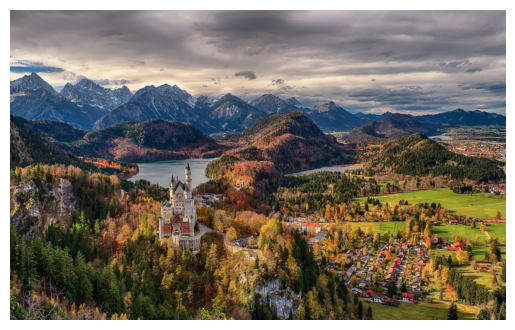

In [19]:
# show final_img - You can make animation for it while solving puzzle. That's fun!
plt.imshow(final_img)
plt.axis('off')
plt.show()

In [21]:
import cv2

# مسیر برای ذخیره ویدیو
video_path = "puzzle22_assembly.mp4"


frames = []


tile_h, tile_w, _ = patches[0].shape
frame_h = rows * tile_h
frame_w = cols * tile_w

# ایجاد تصویر اولیه سیاه
current_frame = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)

# تنظیمات ویدیو: fps و writer
fps = 10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # کدک mp4
video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_w, frame_h))

# دوباره پر کردن پازل ولی این بار همراه با ثبت ویدیو
used_indices.clear()
used_indices.update([-1, -2, -3, -4])  # گوشه‌ها

puzzle_grid = [[None for _ in range(cols)] for _ in range(rows)]

# جایگذاری گوشه‌ها
corner_map = {
    (0, 0): -1,
    (0, cols-1): -2,
    (rows-1, 0): -3,
    (rows-1, cols-1): -4,
}
for (r, c), cid in corner_map.items():
    tile = next(t for t in tiles if t.id == cid)
    puzzle_grid[r][c] = tile
    current_frame[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = tile.image
    video_writer.write(current_frame.copy())

# پر کردن بقیه‌ی پازل همراه با ذخیره‌ی فریم
for i in range(rows):
    for j in range(cols):
        if puzzle_grid[i][j] is not None:
            continue

        best_tile = find_best_tile(i, j)
        puzzle_grid[i][j] = best_tile
        used_indices.add(best_tile.id)

        # آپدیت current_frame
        current_frame[i*tile_h:(i+1)*tile_h, j*tile_w:(j+1)*tile_w, :] = best_tile.image

        # اضافه کردن فریم جدید به ویدیو
        video_writer.write(current_frame.copy())

# پایان ویدیو
video_writer.release()
print(f"✅ The puzzle assembly video was successfully saved to the path {video_path}.")


from google.colab import files
files.download("puzzle22_assembly.mp4")


✅ The puzzle assembly video was successfully saved to the path puzzle22_assembly.mp4.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>